In [1]:
import torch
import torch.nn as nn
import torchvision 
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
import torchvision.models as models
from torchsummary import summary
import torch.utils.model_zoo as model_zoo
import random
import numpy as np
import matplotlib.pyplot as plt
from efficientnet_pytorch import EfficientNet
from torchvision.transforms import InterpolationMode
device = 'cuda' if torch.cuda.is_available else 'cpu'

embedding_dims = 2
batch_size = 256

In [2]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()
    
class CIFAR_DATASET_FOR_SIAMESE(Dataset):
    def __init__(self, datasets, train=True, transform=None):
        self.input_size = 28
        self.channel = 1
        self.is_train = train
        self.transform = transform
        self.to_pil = transforms.ToPILImage()
        
        if self.is_train:            
            self.images = np.array(datasets.data)
            self.labels = np.array(datasets.targets)
            self.index = np.arange(len(datasets.targets))
        else:
            self.images = datasets.data
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, item):
        anchor_img = self.images[item].reshape(self.input_size, self.input_size, self.channel)
        
        if self.is_train:
            anchor_label = self.labels[item]

            positive_list = self.index[self.index!=item][self.labels[self.index!=item]==anchor_label]

            positive_item = random.choice(positive_list)
            positive_img = self.images[positive_item].reshape(self.input_size, self.input_size, self.channel)
            
            negative_list = self.index[self.index!=item][self.labels[self.index!=item]!=anchor_label]
            negative_item = random.choice(negative_list)
            negative_img = self.images[negative_item].reshape(self.input_size, self.input_size, self.channel)
            
            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
                positive_img = self.transform(self.to_pil(positive_img))
                negative_img = self.transform(self.to_pil(negative_img))
            
            return anchor_img, positive_img, negative_img, anchor_label
        
        else:
            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
            return anchor_img
        
# Simple Learning Rate Scheduler
def lr_scheduler(optimizer, epoch):
    lr =  0.001
    if epoch >= 50:
        lr /= 10
    if epoch >= 100:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Xavier         
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [3]:
transform_train = transforms.Compose([
    # transforms.RandomCrop(28, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(size = (28, 28), interpolation = (32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# train_org = torchvision.datasets.CIFAR10(root='./cifar10', train=True, download=True, transform=transform_train)
train_org = torchvision.datasets.MNIST(root='./MNIST', train=True, download=True, transform=transform_train)
test_org = torchvision.datasets.MNIST(root='./MNIST', train=False, download=True, transform=transform_train)

In [4]:
train_org.data = train_org.data[:1000, : ,:]
train_org.targets = train_org.targets[:1000]

torch.Size([28, 28])
tensor(4)
4 - four


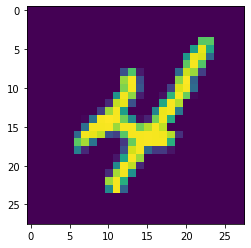

In [5]:
idx = 9
print(train_org.data[idx, : ,:].shape)
plt.imshow(train_org.data[idx, : ,:])
print(train_org.targets[idx])
print(train_org.classes[train_org.targets[idx]])

In [6]:
train_ds = CIFAR_DATASET_FOR_SIAMESE(train_org, 
                 train=True,
                 transform=transforms.Compose([
                     transforms.Resize(size = (32, 32), interpolation=InterpolationMode.BICUBIC),
                     transforms.ToTensor()
                     
                 ]))

test_ds = CIFAR_DATASET_FOR_SIAMESE(test_org, 
                 train=True,
                 transform=transforms.Compose([
                     transforms.Resize(size = (32, 32), interpolation=InterpolationMode.BICUBIC),
                     transforms.ToTensor()
                 ]))

trainloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
testloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)

In [7]:
class models_for_classification(nn.Module):
    def __init__(self, model_name, in_channels, embedding_dims):
        self.available_models = ['resnet18', 'resnet50', 'efficientNet-B0']
        self.model_name = model_name
        self.in_channels = in_channels
        self.embedding_dims = embedding_dims
        self.device = 'cuda' if torch.cuda.is_available else 'cpu'
        
    def select_models(self):
        if self.model_name == 'resnet18':
            print('Resnet model has been selected')
            model = models.resnet18(pretrained=True)
            model.conv1 = nn.Conv2d(self.in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
            model.fc = nn.Linear(512, self.embedding_dims)
            return model
        
        elif self.model_name == 'efficientNet-B0':
            print('efficientNet B0 model has been selected')
            model = EfficientNet.from_pretrained('efficientnet-b0', in_channels=self.in_channels)
            model._conv_stem.in_channels = self.in_channels
            model._fc = nn.Linear(in_features=1280, out_features=self.embedding_dims, bias=True)
            return model
        
        else:
            raise Exception('Re-Try model name. This is no in this available model list ==> {}'.format(self.model_name))
            
    def check_architecture(self, model):
        summary(model, input_size=(self.in_channels, 28, 28))
        
        
model_selector = models_for_classification(model_name = 'resnet18', 
                                      in_channels = 1,
                                     embedding_dims = embedding_dims)

model = model_selector.select_models()

Resnet model has been selected


In [9]:
model.to(device)
model.apply(init_weights)
# model = torch.jit.script(model).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 5e-4)
criterion = torch.jit.script(TripletLoss())

In [10]:
train_loss = 0
valid_loss = 0
correct = 0
total_cnt = 0
best_acc = 0
epochs = 100
    
for epoch in tqdm(range(epochs), desc="Epochs"):
    running_loss = []
    model.train()
    for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(trainloader, desc="Training", leave=False)):
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)
        
        optimizer.zero_grad()
        anchor_out = model(anchor_img)
        positive_out = model(positive_img)
        negative_out = model(negative_img)
        
        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.cpu().detach().numpy())
    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, epochs, np.mean(running_loss)))
    
    
    correct = 0
    total_cnt = 0
    with torch.no_grad():
        model.eval()
        validation_loss = []
        for step, batch in enumerate(testloader):
            anchor_img = anchor_img.to(device)
            positive_img = positive_img.to(device)
            negative_img = negative_img.to(device)
        
            anchor_out = model(anchor_img)
            positive_out = model(positive_img)
            negative_out = model(negative_img)
            
            valid_loss = criterion(anchor_out, positive_out, negative_out)
            validation_loss.append(valid_loss.cpu().detach().numpy())
                                
        print(f"Valid Loss : { np.mean(validation_loss) }")

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 1/100 - Loss: 5.2912
Valid Loss : 0.9291396141052246


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 2/100 - Loss: 3.5777
Valid Loss : 1.2590876817703247


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 3/100 - Loss: 2.8257
Valid Loss : 1.5354198217391968


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 4/100 - Loss: 2.1645
Valid Loss : 1.8016278743743896


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 5/100 - Loss: 1.8129
Valid Loss : 1.425750970840454


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 6/100 - Loss: 1.2471
Valid Loss : 1.3170593976974487


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 7/100 - Loss: 1.0709
Valid Loss : 0.8717944622039795


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 8/100 - Loss: 0.8685
Valid Loss : 0.7840710282325745


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 9/100 - Loss: 0.8466
Valid Loss : 0.7333824634552002


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 10/100 - Loss: 0.6896
Valid Loss : 0.5037756562232971


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 11/100 - Loss: 0.6882
Valid Loss : 0.49503234028816223


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 12/100 - Loss: 0.5455
Valid Loss : 0.5224329233169556


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 13/100 - Loss: 0.5818
Valid Loss : 0.4582813084125519


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 14/100 - Loss: 0.4702
Valid Loss : 0.37100404500961304


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 15/100 - Loss: 0.4342
Valid Loss : 0.3111703395843506


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 16/100 - Loss: 0.4034
Valid Loss : 0.3010663688182831


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 17/100 - Loss: 0.3802
Valid Loss : 0.3772523105144501


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 18/100 - Loss: 0.3620
Valid Loss : 0.29173600673675537


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 19/100 - Loss: 0.3423
Valid Loss : 0.2649784982204437


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 20/100 - Loss: 0.3140
Valid Loss : 0.2376658022403717


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 21/100 - Loss: 0.2857
Valid Loss : 0.23427338898181915


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 22/100 - Loss: 0.2765
Valid Loss : 0.21250322461128235


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 23/100 - Loss: 0.2511
Valid Loss : 0.1856294423341751


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 24/100 - Loss: 0.2759
Valid Loss : 0.20657512545585632


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 25/100 - Loss: 0.2516
Valid Loss : 0.20619888603687286


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 26/100 - Loss: 0.1995
Valid Loss : 0.23239612579345703


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 27/100 - Loss: 0.2167
Valid Loss : 0.139090895652771


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 28/100 - Loss: 0.1427
Valid Loss : 0.1317189484834671


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 29/100 - Loss: 0.2027
Valid Loss : 0.13158904016017914


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 30/100 - Loss: 0.1492
Valid Loss : 0.08901829272508621


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 31/100 - Loss: 0.1632
Valid Loss : 0.1107979342341423


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 32/100 - Loss: 0.1553
Valid Loss : 0.10795440524816513


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 33/100 - Loss: 0.1306
Valid Loss : 0.09173999726772308


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 34/100 - Loss: 0.1346
Valid Loss : 0.09321053326129913


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 35/100 - Loss: 0.1101
Valid Loss : 0.06778624653816223


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 36/100 - Loss: 0.1261
Valid Loss : 0.0527365542948246


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 37/100 - Loss: 0.1206
Valid Loss : 0.06269099563360214


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 38/100 - Loss: 0.0983
Valid Loss : 0.0382094644010067


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 39/100 - Loss: 0.1001
Valid Loss : 0.04632116109132767


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 40/100 - Loss: 0.0886
Valid Loss : 0.07208774983882904


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 41/100 - Loss: 0.1115
Valid Loss : 0.053020961582660675


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 42/100 - Loss: 0.0958
Valid Loss : 0.05319638177752495


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 43/100 - Loss: 0.1052
Valid Loss : 0.04749973118305206


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 44/100 - Loss: 0.1133
Valid Loss : 0.04191967844963074


Training:   0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: 

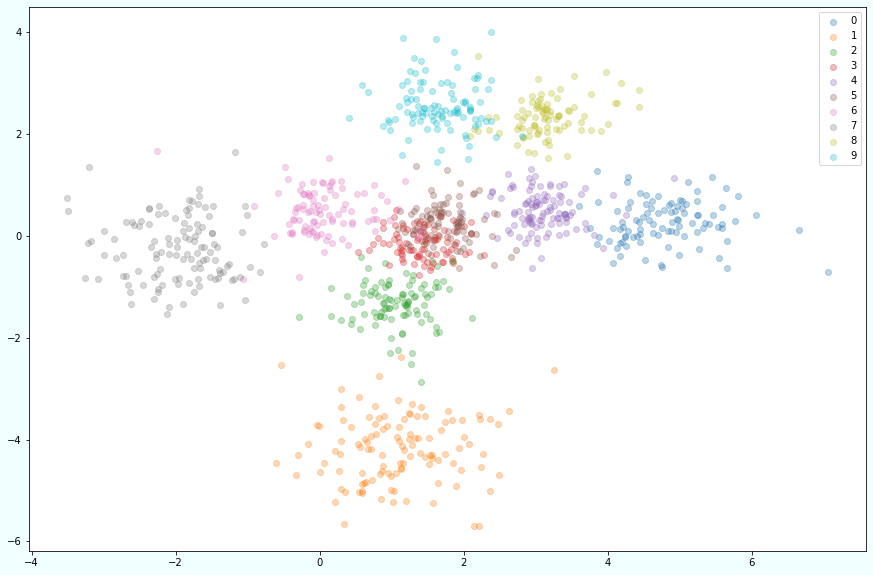

In [11]:
train_results =[]
labels =[]

with torch.no_grad():
    model.eval()
    for img, _, _, label in trainloader:
        train_results.append(model(img.to(device)).cpu().numpy())
        labels.append(label)
        
train_results = np.concatenate(train_results)
labels = np.concatenate(labels)

plt.figure(figsize=(15, 10), facecolor="azure")
for label in np.unique(labels):
    tmp = train_results[labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label,  alpha = 0.3)

plt.legend()
plt.show()